In [5]:
import pandas as pd
import numpy as np
import yfinance as yf

tickers = ["MSFT"]
start_date = "2015-07-01"
end_date = "2025-07-31"
msft_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)
msft_data.ffill(inplace=True)

msft_price = msft_data['Adj Close']

split_date = '2024-01-01'
train_data = msft_price.loc[:split_date].dropna()
test_data = msft_price.loc[split_date:].dropna()

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

[*********************100%***********************]  1 of 1 completed

Training data size: 2140
Testing data size: 395


[*********************100%***********************]  1 of 1 completed


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2140
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5597.665
Date:                Tue, 12 Aug 2025   AIC                          11203.329
Time:                        12:32:10   BIC                          11226.002
Sample:                             0   HQIC                         11211.626
                               - 2140                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1100      0.048      2.305      0.021       0.016       0.204
ar.L1          0.2935      0.102      2.880      0.004       0.094       0.493
ma.L1         -0.4019      0.099     -4.045      0.0

c:\Users\josib\Documents\GMF_Portfolio_Optimization\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\josib\Documents\GMF_Portfolio_Optimization\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


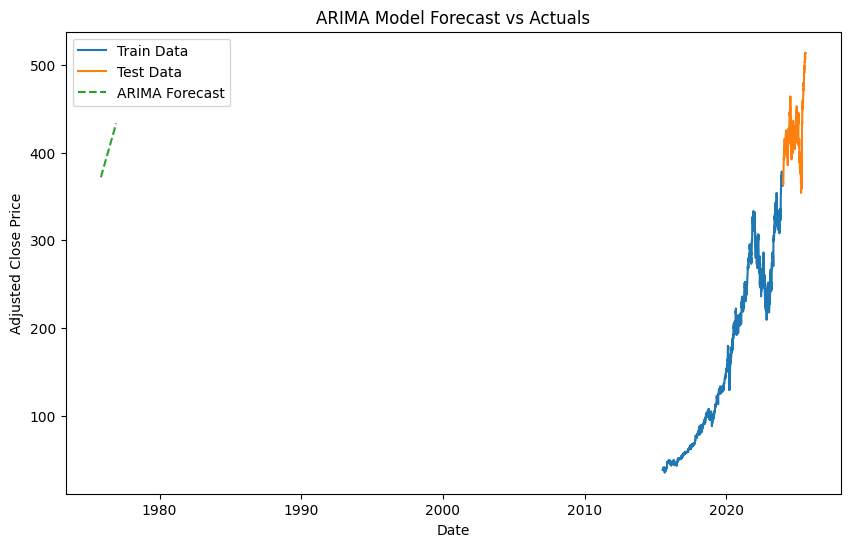

In [ ]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

tickers = ["MSFT"]
start_date = "2015-07-01"
end_date = "2025-07-31"
msft_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)
msft_data.ffill(inplace=True)
msft_data.dropna(inplace=True)

msft_price = msft_data['Adj Close']

split_date = '2024-01-01'
train_data = msft_price.loc[:split_date].dropna()
test_data = msft_price.loc[split_date:].dropna()

arima_model = pm.auto_arima(train_data, seasonal=False, stepwise=True,
                            suppress_warnings=True, D=1, max_d=1)

print(arima_model.summary())

n_periods = len(test_data)
arima_forecast = arima_model.predict(n_periods=n_periods)

arima_forecast_clean = arima_forecast[:len(test_data)]
test_data_clean = test_data.dropna()

if len(arima_forecast_clean) != len(test_data_clean):
    min_len = min(len(arima_forecast_clean), len(test_data_clean))
    arima_forecast_clean = arima_forecast_clean[:min_len]
    test_data_clean = test_data_clean[:min_len]

arima_rmse = sqrt(mean_squared_error(test_data_clean, arima_forecast_clean))
arima_mae = mean_absolute_error(test_data_clean, arima_forecast_clean)
arima_mape = mean_absolute_percentage_error(test_data_clean, arima_forecast_clean)

print("ARIMA Model Performance:")
print(f"RMSE: {arima_rmse}")
print(f"MAE: {arima_mae}")
print(f"MAPE: {arima_mape}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_data.index, train_data, label='Train Data')
ax.plot(test_data_clean.index, test_data_clean, label='Test Data')
ax.plot(arima_forecast_clean.index, arima_forecast_clean, label='ARIMA Forecast', linestyle='--')
ax.set_title('ARIMA Model Forecast vs Actuals')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close Price')
ax.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

tickers = ["MSFT"]
start_date = "2015-07-01"
end_date = "2025-07-31"
msft_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)
msft_data.ffill(inplace=True)
msft_data.dropna(inplace=True)
msft_price = msft_data['Adj Close']

split_date = '2024-01-01'
train_data = msft_price.loc[:split_date].values.reshape(-1, 1)
test_data = msft_price.loc[split_date:].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 60
X_train_seq, y_train_seq = create_sequences(train_scaled, look_back)
X_test_seq, y_test_seq = create_sequences(test_scaled, look_back)

X_train_tensor = torch.from_numpy(X_train_seq).float().unsqueeze(2)
y_train_tensor = torch.from_numpy(y_train_seq).float()
X_test_tensor = torch.from_numpy(X_test_seq).float().unsqueeze(2)
y_test_tensor = torch.from_numpy(y_test_seq).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize and train the model
model = LSTMModel(input_size=1, hidden_size=50, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25
for epoch in range(num_epochs):
    for i, (sequences, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/25], Loss: 0.0311
Epoch [2/25], Loss: 0.0027
Epoch [3/25], Loss: 0.0008
Epoch [4/25], Loss: 0.0010
Epoch [5/25], Loss: 0.0015
Epoch [6/25], Loss: 0.0007
Epoch [7/25], Loss: 0.0008
Epoch [8/25], Loss: 0.0008
Epoch [9/25], Loss: 0.0005
Epoch [10/25], Loss: 0.0006
Epoch [11/25], Loss: 0.0004
Epoch [12/25], Loss: 0.0009
Epoch [13/25], Loss: 0.0005
Epoch [14/25], Loss: 0.0005
Epoch [15/25], Loss: 0.0010
Epoch [16/25], Loss: 0.0010
Epoch [17/25], Loss: 0.0006
Epoch [18/25], Loss: 0.0005
Epoch [19/25], Loss: 0.0016
Epoch [20/25], Loss: 0.0006
Epoch [21/25], Loss: 0.0005
Epoch [22/25], Loss: 0.0003
Epoch [23/25], Loss: 0.0006
Epoch [24/25], Loss: 0.0007
Epoch [25/25], Loss: 0.0003


PyTorch LSTM Model Performance:
RMSE: 17.879742016154683
MAE: 14.543594496997434
MAPE: 0.033136830060181525


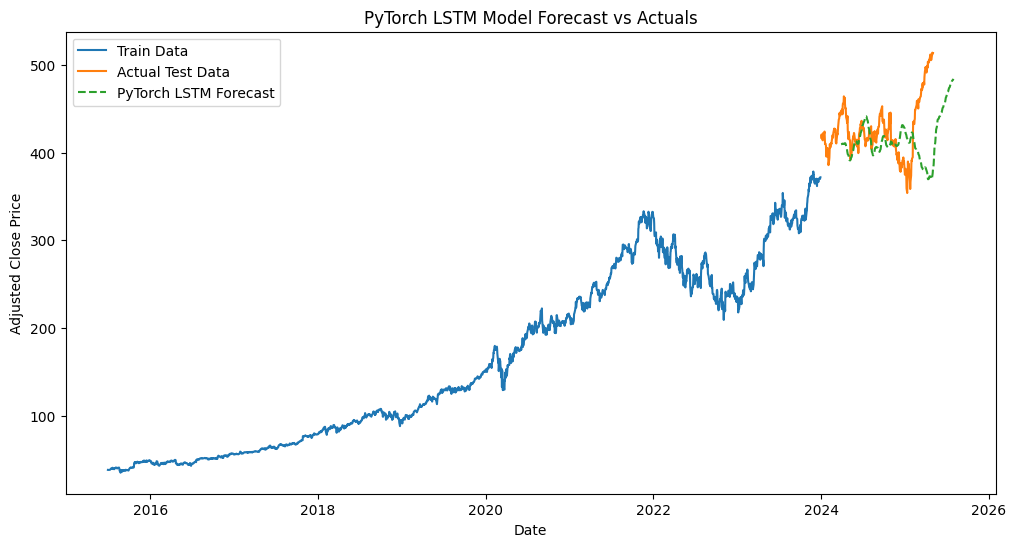

In [ ]:
# Make predictions on test data
model.eval()
with torch.no_grad():
    lstm_predictions_scaled = model(X_test_tensor).numpy()

# Inverse transform the predictions to the original price scale
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Align the predictions with the original test data for evaluation
test_data_eval = msft_price.loc[split_date:].values.flatten()[look_back:]

# Evaluate LSTM model performance
lstm_rmse = sqrt(mean_squared_error(test_data_eval, lstm_predictions))
lstm_mae = mean_absolute_error(test_data_eval, lstm_predictions)
lstm_mape = mean_absolute_percentage_error(test_data_eval, lstm_predictions)

print("PyTorch LSTM Model Performance:")
print(f"RMSE: {lstm_rmse}")
print(f"MAE: {lstm_mae}")
print(f"MAPE: {lstm_mape}")

# Visualize the forecast
plt.figure(figsize=(12, 6))
plt.plot(msft_price.index[:len(train_data)], msft_price.loc[:split_date], label='Train Data')
plt.plot(msft_price.index[len(train_data):len(train_data)+len(test_data_eval)], test_data_eval, label='Actual Test Data')
plt.plot(msft_price.index[len(train_data)+look_back:len(train_data)+len(test_data_eval)+look_back], lstm_predictions, label='PyTorch LSTM Forecast', linestyle='--')
plt.title('PyTorch LSTM Model Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()